In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings

### 讀入user資料

In [2]:
user_ratings = pd.read_csv('u.data',sep='\t',names=['user_id','movie_id','rating'], usecols=[0,1,2])
movie_info =  pd.read_csv('u.item', sep='|', names=['movie_id','title'], usecols=[0,1],encoding="ISO-8859-1")
user_ratings = pd.merge(movie_info, user_ratings)
user_ratings.head()

,movie_id,title,user_id,rating
0,1,Toy Story (1995),308,4
1,1,Toy Story (1995),287,5
2,1,Toy Story (1995),148,4
3,1,Toy Story (1995),280,4
4,1,Toy Story (1995),66,3


### user資料加入index

In [3]:
user_ratings =user_ratings.pivot_table(index=['user_id'],columns=['title'],values='rating')
user_ratings.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


### 印出有打分數的區塊占總表格的比例

In [4]:
def df_fill_percentage(data):
    return round( data.notna().sum().sum() / (data.shape[0] * data.shape[1]) * 100, 2)

In [5]:
df_fill_percentage(user_ratings)


6.35

### 顯示只有少部分的電影有被評分的現象

<AxesSubplot:ylabel='Density'>

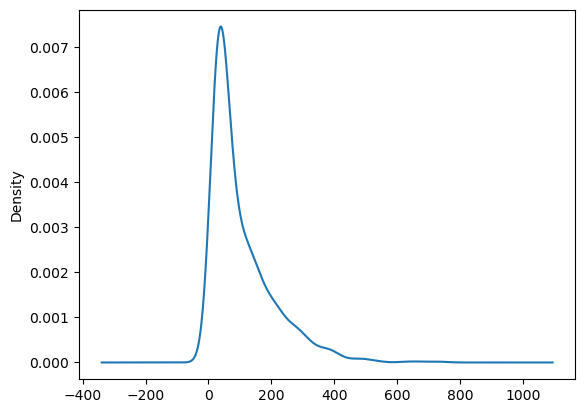

In [6]:
user_ratings.count(axis=1).plot(kind='kde')

### 使用皮爾森係數去計算距離，當作相關性的值，並且整理，只留下篩選後的資料

In [7]:
user_distances = user_ratings.transpose().corr(method='pearson')

In [8]:
#留下最相近的10筆資料
nneighbors = 10
user_distances = user_distances.dropna(axis=0, thresh=nneighbors+1).dropna(axis=1, thresh=nneighbors+1)

# 移除多餘的行
user_distances = user_distances.loc[user_distances.columns]

### 將距離係數範圍移到-1和1之間，並將負值都計為0

In [9]:
user_distances = 1.0 - user_distances
user_distances[user_distances < 0] = 0

### 設定KNN模型，由於資料中會出現0項，KNN模型只對非零項作運算。


In [10]:
#設定knn訓練模型，其中n_neighbors=10，利用鄰近10個項目作為參考。
model_knn = NearestNeighbors(metric='precomputed', algorithm='brute', n_neighbors=10, n_jobs=-1)
#只考慮非零項
model_knn.fit(csr_matrix(user_distances.fillna(0).values))
#預測
similarity, indexes = model_knn.kneighbors(csr_matrix(user_distances.fillna(0).values), n_neighbors=nneighbors)

C:\Users\611121209\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


### 求出最相關的10筆資料後，套回原本的電影名稱。

In [11]:
neighborhoods = pd.DataFrame({'neighborhood_ids':[user_distances.iloc[neighbors].index.to_list() 
                                                for neighbors in indexes], 
                              'distance': similarity.tolist()}, 
                             index=user_distances.index)
neighborhoods
#算出每一個人推薦的十部電影及距離

,neighborhood_ids,distance
user_id,,
1,"[520, 107, 687, 34, 105, 740, 485, 400, 873, 510]","[0.08144134645630818, 0.08346578621692213, 0.0..."
2,"[426, 341, 476, 267, 310, 766, 352, 162, 338, ...","[1.1102230246251565e-16, 0.015268072165338209,..."
3,"[618, 879, 368, 563, 359, 906, 867, 512, 452, ...","[2.220446049250313e-16, 2.220446049250313e-16,..."
4,"[825, 899, 739, 169, 812, 168, 325, 80, 369, 711]","[2.220446049250313e-16, 0.015268072165338209, ..."
5,"[728, 791, 482, 565, 797, 415, 781, 931, 571, ...","[0.018019493938034148, 0.029274656605848937, 0..."
...,...,...
939,"[482, 578, 640, 728, 832, 609, 397, 451, 492, ...","[1.1102230246251565e-16, 1.1102230246251565e-1..."
940,"[726, 859, 300, 105, 289, 4, 510, 428, 353, 872]","[0.018019493938034148, 0.01801949393803437, 0...."
941,"[801, 243, 350, 781, 841, 451, 610, 93, 431, 574]","[1.1102230246251565e-16, 2.220446049250313e-16..."


In [12]:
neighbors = neighborhoods['neighborhood_ids'].loc[1]
neighbors

[520, 107, 687, 34, 105, 740, 485, 400, 873, 510]

In [13]:
#印出全部人的平均打分
user_ratings.loc[neighbors].mean()

title
'Til There Was You (1997)                NaN
1-900 (1994)                             NaN
101 Dalmatians (1996)                    NaN
12 Angry Men (1957)                      NaN
187 (1997)                               2.5
                                        ... 
Young Guns II (1990)                     NaN
Young Poisoner's Handbook, The (1995)    NaN
Zeus and Roxanne (1997)                  NaN
unknown                                  NaN
Á köldum klaka (Cold Fever) (1994)       NaN
Length: 1664, dtype: float64

### 利用全部打分的平均去重新計算每個人給的分數

In [14]:
def usercf_predict_rating_closure(user_ratings, neighborhoods):
    # creates the function to predict ratings
    def usercf_predict_rating_using_nmean(row):
        neighbors_ids = neighborhoods['neighborhood_ids'].loc[row.name]
        # calculate predictions
        pred_ratings = user_ratings.loc[neighbors_ids].mean()
        return round(pred_ratings)
    
    return usercf_predict_rating_using_nmean

### 計算每一個人之間的距離作為判斷相似的依據

In [15]:
def recommendation_system_user_model(minperiods, nneighbors, user_ratings):
    user_distances = user_ratings.transpose().corr(method='pearson', min_periods=minperiods)
    #利用皮爾森係數算每個人的距離，並只保留相關的資料
    user_distances = user_distances.dropna(axis=0, thresh=nneighbors+1).dropna(axis=1, thresh=nneighbors+1)
    user_distances = user_distances.loc[user_distances.columns]
    #將結果移到-1和1之間
    user_distances = 1 - user_distances
    #把負數去掉
    user_distances[user_distances < 0] = 0
    #KNN模型建立
    model_knn = NearestNeighbors(metric='precomputed', algorithm='brute', n_neighbors=nneighbors, n_jobs=-1)
    model_knn.fit(csr_matrix(user_distances.fillna(0).values))
    #預測
    similarity, indexes = model_knn.kneighbors(csr_matrix(user_distances.fillna(0).values), n_neighbors=nneighbors)
    #把預測的結果對照回原本的資料
    neighborhoods = pd.DataFrame({'neighborhood_ids':[user_distances.iloc[neighbors].index.to_list() for neighbors in indexes], 
                                  'distance': similarity.tolist()}, 
                                 index=user_distances.index)
    #利用平均去計算打分 
    pred = user_ratings.reindex(neighborhoods.index).apply(usercf_predict_rating_closure(user_ratings,neighborhoods), 
                                                           axis='columns')
    #將預測的打分重新加回原本的資料中
    user_ratings.merge(pred, how='right')
    return pred, neighborhoods

### 利用MAE function去計算執行的成果好壞

In [16]:
def mae(user_ratings, predicted_ratings):
    abs_dif = abs(user_ratings - predicted_ratings)
    #處理有些電影未被評分的問題
    n = np.sum(user_ratings.count()) 
    return abs_dif.sum().sum()/ n

In [17]:
def mse(user_ratings, predicted_ratings):
    abs_dif = (user_ratings - predicted_ratings)*(user_ratings - predicted_ratings)
#     #處理有些電影未被評分的問題
    n = np.sum(user_ratings.count()) 
    return abs_dif.sum().sum()/ n

In [18]:
def rmse(user_ratings, predicted_ratings):
    abs_dif = (user_ratings - predicted_ratings)*(user_ratings - predicted_ratings)
#     #處理有些電影未被評分的問題
    n = np.sum(user_ratings.count()) 
    return np.sqrt(abs_dif.sum().sum()/ n)

### 讀取要訓練和測試的資料集

In [19]:
user_ratings_train = pd.read_csv('ub.base',sep='\t',names=['user_id','movie_id','rating'], usecols=[0,1,2])

user_ratings_test = pd.read_csv('ub.test',sep='\t',names=['user_id','movie_id','rating'], usecols=[0,1,2])

movie_info =  pd.read_csv('u.item', sep='|', names=['movie_id','title'], usecols=[0,1],encoding="ISO-8859-1")

# 將user資料和電影的資料合成一個檔案
user_ratings_train = pd.merge(movie_info, user_ratings_train)
user_ratings_test = pd.merge(movie_info, user_ratings_test)

#將user的id和打分合成一份資料，並給資料的欄位名稱
user_ratings_train = user_ratings_train.pivot_table(index=['user_id'],columns=['title'],values='rating')

user_ratings_test = user_ratings_test.pivot_table(index=['user_id'],columns=['title'],values='rating')

print(user_ratings_train.shape)
print(user_ratings_test.shape)

(943, 1658)
(943, 1135)


In [20]:
user_ratings_train = user_ratings_train.reindex(
                            index=user_ratings_train.index.union(user_ratings_test.index), 
                            columns=user_ratings_train.columns.union(user_ratings_test.columns) )

user_ratings_test = user_ratings_test.reindex(
                            index=user_ratings_train.index.union(user_ratings_test.index), 
                            columns=user_ratings_train.columns.union(user_ratings_test.columns) )

print(user_ratings_train.shape)
print(user_ratings_test.shape)

(943, 1664)
(943, 1664)


In [21]:
scoreboard = []
for min_periods in [5, 10, 50, 100]:
    for n_neighbors in [2, 5, 10, 20, 30]:
        # temporarily supress warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pred, neighborhoods = recommendation_system_user_model(min_periods, 
                                                                   n_neighbors, 
                                                                   user_ratings_train)
        #有些欄位會因為沒有足夠的鄰居去計算而被誤填，需要重新排列index重新去計算一次
        pred = pred.reindex(index=user_ratings_train.index)
        # 利用MAE去計算error
        error = mae(user_ratings_test, pred)
        # 計算未被評分的電影比例
        m_not_rec = (pred.notna().sum(axis=0) == 0).sum() / pred.columns.size * 100
        # 計算沒有評論的user
        u_not_rec = (pred.notna().sum(axis=1) == 0).sum() / pred.index.size * 100
        d = {"Min Periods": min_periods, 
             "KNN":n_neighbors,"MAE": error, 
             "% of movies ignored": m_not_rec, '% of users ignored': u_not_rec,
             "fill %": df_fill_percentage(pred)}
        scoreboard.append(d)
scores = pd.DataFrame(scoreboard)
scores

,Min Periods,KNN,MAE,% of movies ignored,% of users ignored,fill %
0,5,2,0.259711,2.524038,0.000000,8.21
1,5,5,0.406973,0.600962,0.000000,16.37
2,5,10,0.521280,0.360577,0.000000,25.48
3,5,20,0.620304,0.360577,0.212089,37.15
4,5,30,0.672734,0.360577,0.530223,44.79
5,10,2,0.388930,1.081731,3.075292,14.07
6,10,5,0.499629,0.360577,6.256628,23.74
7,10,10,0.560125,0.360577,9.756098,32.09
8,10,20,0.604543,0.360577,13.997879,41.15
9,10,30,0.625769,0.420673,15.376458,47.47


### 執行預測並計算error

In [22]:
pred_user, neighborhoods_user = recommendation_system_user_model(5, 10, user_ratings_train)
pred_user = pred_user.reindex(index=user_ratings_train.index)

C:\Users\611121209\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


In [23]:
# compare to the test set using MAE
error = mse(user_ratings_test, pred_user)
error

0.896439184886436

In [24]:
# compare to the test set using RMSE
error = rmse(user_ratings_test, pred_user)
error

0.9468047237347499

In [25]:
pred_user, neighborhoods_user = recommendation_system_user_model(5, 10, user_ratings_train)
pred_user = pred_user.reindex(index=user_ratings_train.index)

C:\Users\611121209\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(
